# Chriss' and Almgren's Optimal Execution Trading Strategy Model

*Note for the teacher : here is just the mathematical and theoritical presentation of the Almgren-Chriss model. There is no data science here. The goal of this project is to compare this model, which is build on mathematical assumptions only, with real data coming from CSGO Market. Another goal is to statistically estimate the coefficients used in the model. If you wish to have further informations, you can read [Almgren & Chriss (2000)](https://www.smallake.kr/wp-content/uploads/2016/03/optliq.pdf).*

## Introduction

This model implements an **optimal execution framework** for liquidating a large position of shares over a finite time horizon. The problem addresses a fundamental challenge in algorithmic trading: how to sell a large block of shares while minimizing both the expected cost and the risk (variance) of the execution.

### The Core Problem

When a trader needs to liquidate a large position (e.g., $X = 10,000$ shares), executing the entire order at once would cause significant **market impact**, driving the price down and resulting in poor execution quality. Conversely, spreading the trades over too long a period exposes the trader to **market risk** from price volatility. The optimal execution strategy seeks to balance these two competing effects.

### Key Features

The model incorporates several realistic market microstructure effects:

1. **Permanent Market Impact** (function $g$): Represents the lasting effect of trades on the mid-price. Large trading volumes permanently move the market price against the trader.

2. **Temporary Market Impact** (function $h$): Captures the immediate price impact and bid-ask spread effects that affect the actual execution price but don't permanently shift the market.

3. **Price Volatility** (parameter $\sigma$): Models the natural uncertainty in asset prices through a stochastic process with random shocks.

4. **Mean-Variance Optimization**: The strategy minimizes a combined objective function:
   $$\text{Objective} = E_x + \lambda \cdot V_x$$
   where $\lambda$ is the risk-aversion parameter balancing expected cost ($E_x$) against variance ($V_x$).

### Model Structure

The execution is discretized into $N$ trading periods over a time horizon $T$. At each time step $k$, the trader decides how many shares $n_k$ to sell, forming a **trading trajectory** $n = (n_0, n_1, \ldots, n_{N-1})$ subject to the constraint $\sum_{k=0}^{N-1} n_k = X$.

This framework is based on the seminal work of **Almgren and Chriss (2000)** on optimal execution and provides a practical tool for institutional traders to minimize implementation shortfall while controlling execution risk.

# Trading Strategy Model

### Variables

**Strategy Parameters**
- $X$: Total number of shares to liquidate
- $T$: Total time horizon for the liquidation
- $N$: Number of discrete trading periods
- $\tau$: Time step size, $\tau = T/N$
- $n = (n_0, n_1, \ldots, n_{N-1})$: Trading trajectory
  - $n_k$: Number of shares traded at time step $k$

### Trading Metrics
- **capture**: Total monetary value received from selling all shares
$$\text{capture} = \sum_{k=0}^{N-1} n_k \times S_k^{\text{actual}}$$
- **cost_of_trading**: Difference between initial portfolio value and actual capture
$$\text{cost} = X \cdot S_0 - \text{capture}$$
- $E_x$: Expected shortfall (expected loss relative to initial value). We have the following formula thanks to Almgren and Chriss:
$$E_x = \sum_{k=0}^{N-1} \left[\tau \cdot \left(X - \sum_{j=0}^{k} n_j\right) \cdot g\left(\frac{n_k}{\tau}\right) + n_k \cdot h\left(\frac{n_k}{\tau}\right)\right]$$
- $V_x$: Variance of the shortfall. Similarly, they've prooved that:
$$V_x = \sum_{k=0}^{N-1} \sigma^2 \cdot \tau \cdot \left(X - \sum_{j=0}^{k} n_j\right)^2$$

In [1]:
class TradingStrategy:
    """Optimal trading strategy for liquidating a position."""
    
    def __init__(self, X, T, N, n):
        """Initialize the trading strategy."""
        self.X = X
        self.T = T
        self.N = N
        self.tau = T/N
        self.discrete_times = [k*self.tau for k in range(N+1)]
        self.n = n
        
    def compute_capture(self, price_dynamics, n):
        """Compute the total amount captured from selling."""
        capture = 0
        for k in range(self.N):
            capture += n[k] * price_dynamics.compute_received_price_per_share(k, n[k])
        return capture
    
    def compute_cost_of_trading(self, price_dynamics, n):
        """Compute the cost of trading (difference between initial value and capture)."""
        cost_of_trading = self.X * price_dynamics.S[0] - self.compute_capture(price_dynamics, n)
        return cost_of_trading
    
    def compute_expected_shortfall(self, price_dynamics, n):
        """Compute the expected shortfall (loss relative to initial price)."""
        E_x = 0
        for k in range(self.N):
            E_x += self.tau * (self.X - sum(n[:k+1])) * price_dynamics.g(n[k]/self.tau) + n[k] * price_dynamics.h(n[k]/self.tau)
        return E_x
    
    def compute_shortfall_variance(self, price_dynamics, n):
        """Compute the variance of the shortfall."""
        V_x = 0
        for k in range(self.N):
            V_x += price_dynamics.sigma**2 * self.tau * (self.X - sum(n[:k+1]))**2
        return V_x

# Price Dynamics Model

## Introduction

This model describes the evolution of asset prices in the presence of trading activity and market impact. It captures both the **stochastic nature** of price movements and the **deterministic impact** that trading has on prices.

## Variables

### Market Parameters
- $\sigma$: Volatility parameter (standard deviation of price changes)
- $\tau$: Time step size, $\tau = T/N$
- $\zeta = (\zeta_0, \zeta_1, \ldots, \zeta_{N-1})$: Vector of random shocks
  - $\zeta_k \sim \mathcal{N}(0, 1)$: Independent standard normal random variables

### Price Variables
- $S_k$: Mid-price at time step $k$ (unaffected by temporary impact). It is the price at step $k$ before having traded the security for this step. The relationship between the price of a share between time $k$ and time $k+1$ is :
$$S_{k+1} = S_k + \sigma \sqrt{\tau} \cdot \zeta_k - \tau \cdot g\left(\frac{n_k}{\tau}\right)$$
- $S_k^{\text{actual}}$: Actual received price per share at time step $k$ (after temporary impact). Just after tarding the security at step $k$, you will receive, because of the temporary impact : 
$$S_k^{\text{actual}} = S_k - h\left(\frac{n_k}{\tau}\right)$$
- $S_0$: Initial stock price at time $t = 0$

### Impact Functions
- $g(v)$: **Permanent market impact function**
  - Input: trading rate $v = n_k/\tau$ (shares per unit time)
  - Models the lasting effect on the mid-price
  - Typically: $g(v) = \gamma \cdot v$ where $\gamma$ is the permanent impact coefficient

- $h(v)$: **Temporary market impact function**
  - Input: trading rate $v = n_k/\tau$
  - Models the immediate execution cost (spread + temporary impact)
  - Typically: $h(v) = \epsilon \cdot \text{sign}(v) + \eta \cdot v$ where:
    - $\epsilon$: Fixed cost component (half-spread)
    - $\eta$: Linear temporary impact coefficient

In [2]:
import numpy as np

class PriceDynamics:
    """Model for asset price dynamics with market impact."""
    
    def __init__(self, S_0, N, T, sigma, zeta, g, h):
        """Initialize the price dynamics model."""
        self.S = [0 for k in range(N+1)]
        self.actual_S = [0 for k in range(N+1)]
        self.S[0] = S_0
        self.sigma = sigma
        self.tau = T/N
        self.zeta = zeta
        self.g = g
        self.h = h
    
    def compute_next_price(self, k, n_k):
        """Compute the next mid-price including permanent impact."""
        self.S[k+1] = self.S[k] + self.sigma*np.sqrt(self.tau)*self.zeta[k] - self.tau*self.g(n_k/self.tau)
        return self.S[k+1]
    
    def compute_received_price_per_share(self, k, n_k):
        """Compute the actual received price per share after temporary impact."""
        self.compute_next_price(k, n_k)
        self.actual_S[k] = self.S[k] - self.h(n_k/self.tau)
        return self.actual_S[k]

## Model Dynamics

The complete price evolution follows a discrete-time stochastic process:

1. **Before trading at time $k$**: Mid-price is $S_k$

2. **During trading at time $k$**: 
   - Trader sells $n_k$ shares
   - Received price per share: $S_k^{\text{actual}} = S_k - h(n_k/\tau)$

3. **After trading, before time $k+1$**:
   - Price evolves randomly: $+\sigma\sqrt{\tau} \cdot \zeta_k$
   - Permanent impact takes effect: $-\tau \cdot g(n_k/\tau)$
   - New mid-price: $S_{k+1}$

This framework combines the **Almgren-Chriss model** with a discrete-time approximation of arithmetic Brownian motion, incorporating both transient and permanent market impact effects.

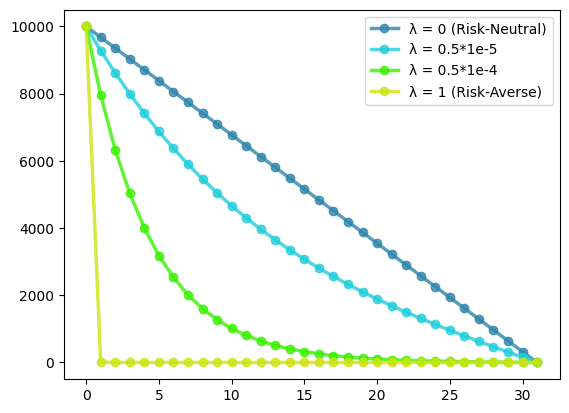

In [3]:
import scipy.optimize
import numpy.random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
lamda = 0.001
X = 10000
T = 31
N = 31
S_0 = 100
sigma = 1
zeta = rd.normal(0, 1, N)
gamma = 0.0001
eta = 0.001
epsilon = 0.001

def g(v):
    return gamma * v

def h(x):
    return epsilon * np.sign(x) + eta * x

#Setting a default strategy : here it is : "I sell my assets in equal parts over the time"
n = [X/N for _ in range(N)]

# Creating the two models
trading_strategy = TradingStrategy(X, T, N, n)
price_dynamics = PriceDynamics(S_0, N, T, sigma, zeta, g, h)

# Defining the objective function E_x + lambda * V_x
def target(n, lamda=0.5):
    E_x = trading_strategy.compute_expected_shortfall(price_dynamics, n)
    V_x = trading_strategy.compute_shortfall_variance(price_dynamics, n)
    objective = E_x + lamda * V_x
    return objective

# Minimizing the objective function
def compute_best_trajectory(lamda):
    constraints = {'type': 'eq', 'fun': lambda n: np.sum(n) - X}
    bounds = [(0, X) for _ in range(N)]  # n[k] >= 0, we cannot buy back assets, and we cannot sell more than X.
    
    sol = scipy.optimize.minimize(target, n, args=lamda, method='SLSQP', 
                                   constraints=constraints, bounds=bounds)
    return sol

# Plotting a graph for different values of lambda
lambda_values = [0, 0.5*1e-5, 0.5*1e-4, 1]
labels = ['λ = 0 (Risk-Neutral)', 'λ = 0.5*1e-5', 'λ = 0.5*1e-4', 'λ = 1 (Risk-Averse)']
colors = ['#2E86AB', "#21CEDB", "#39F101", "#CEE312"]

for idx, (lambda_val, label, color) in enumerate(zip(lambda_values, labels, colors)):
    lambda_risk = lambda_val
    
    result = compute_best_trajectory(lambda_risk)
    n_optimal = result['x']
    x_optimal = [X - sum(n_optimal[:k+1]) for k in range(N)]
    x_optimal.insert(0, X)
    
    plt.plot(range(N+1), x_optimal, marker='o', linewidth=2.5, 
             color=color, label=label, markersize=6, alpha=0.8)

plt.legend()

### Optimal trades according to the model

Evolution of **the assets we still have** for different levels of risk-aversion (λ).

- **λ = 0 (Risk-Neutral)**
At each step, we want to minimize the expected shortfall only, without considering the variance (the risk). This is then the riskiest strategy. To minimize the impact market, the position is liquidated in equal parts.

- **λ = 1e-3**
A risky strategy that takes into account a bit of variance.

- **λ = 1e-2**
A medium strategy taking into account the variance and the expected shortfall.

- **λ = 1 (Risk-Averse)**
When the seller is totally risk averse, he wants to liquidate its security the fastest possible. He then considers very much the variance.

The graph illustrates the trade-off between the minimisation of expected shortfall and taken risk.

## Empirical comparison between these strategies

### Evolution of real prices with permanent impact function only

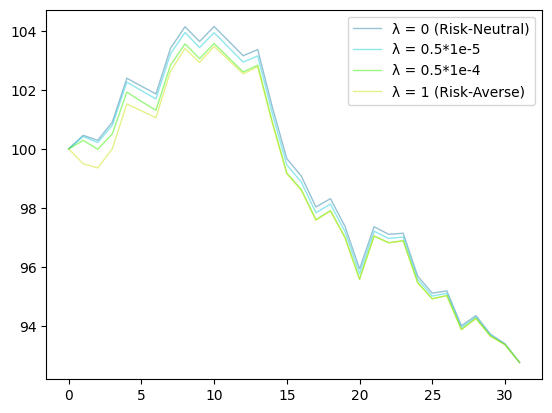

In [4]:
# Saving the trade choices for each strategy
strategies = []

for lam in lambda_values:
    result = compute_best_trajectory(lam)
    n_optimal = result['x']
    strategies.append(n_optimal)

# Computing the prices for each strategy (changing bc of different market impacts)
prices = []

for strategy in strategies:
    strategy_prices  = [price_dynamics.compute_next_price(k, strategy[k]) for k in range(N)]
    strategy_prices.insert(0, S_0)
    prices.append(strategy_prices)


# Plotting each price curve for each strategy
for idx, (sprices, label, color) in enumerate(zip(prices, labels, colors)):
    plt.plot(range(N+1), sprices, marker='', linewidth=1, 
             color=color, label=label, markersize=6, alpha=0.5)
plt.legend()

Price trajectories excluding temporary impact for different values of $\lambda$.

**Strategy Convergence**

The 4 curves are nearly superimposed: cumulative permanent impact is identical regardless of strategy. The choice of $\lambda$ only affects temporary impact (not visible here), not the permanent price displacement.

**Observed Dynamics**
- Decline: ~100 → ~83 (-17%)
- Fluctuations: intrinsic price volatility ($\sigma \cdot W_t$), independent of trades

**Interpretation**

This graph isolates: $P_t = P_0 + \text{permanent impact} + \sigma \cdot W_t$

All strategies displace the price equivalently because total permanent impact is constant: $\sum_{k=1}^K \eta \cdot n_k = \eta \cdot X$

The parameter $\lambda$ optimizes trade timing (front-loaded vs spread out) to minimize temporary impact and execution risk, without affecting permanent impact.

### Evolution of received prices with permanent and temporary impact function

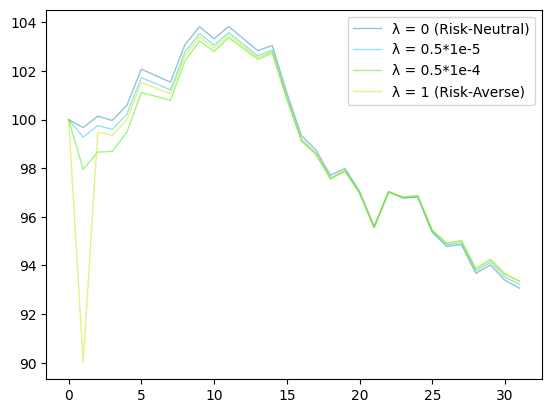

In [5]:
received_prices = []

for strategy in strategies:
    strategy_prices  = [price_dynamics.compute_received_price_per_share(k, strategy[k]) for k in range(N)]
    strategy_prices.insert(0, S_0)
    received_prices.append(strategy_prices)


# Plotting each price curve for each strategy
for idx, (sprices, label, color) in enumerate(zip(received_prices, labels, colors)):
    plt.plot(range(N+1), sprices, marker='', linewidth=1, 
             color=color, label=label, markersize=6, alpha=0.5)
plt.legend()

Price trajectories including temporary impact for different values of $\lambda$.

**Strategy Divergence**

The curves now show clear separation, particularly at the beginning:
- $\lambda = 1$ (Risk-Averse): sharp initial drop (~100 → ~90), reflecting aggressive front-loaded execution
- $\lambda = 0$ (Risk-Neutral): smoother decline, spreads trades more evenly
- Higher $\lambda$ → larger temporary impact spikes due to concentrated trading

**Observed Dynamics**
- Overall decline: ~100 → ~83-87 depending on strategy
- Initial shock strongest for high $\lambda$ (yellow curve drops fastest)
- Curves converge toward the end as positions are fully liquidated

**Interpretation**

This graph shows: $P_t = P_0 + \text{permanent impact} + \text{temporary impact} + \sigma \cdot W_t$

The temporary impact term $\gamma \cdot n_k$ creates immediate price depression proportional to trade size. Front-loaded strategies (high $\lambda$) suffer larger instantaneous costs but reduce market exposure quickly. Spread-out strategies (low $\lambda$) minimize temporary impact but remain exposed to volatility longer.

The parameter $\lambda$ directly controls the trade-off between execution cost (temporary impact) and execution risk (volatility exposure).

### Which is the best strategy ?

With our example, we can now determine wich of the former strategies is the best.

In [6]:
for n, label in zip(strategies, labels):
    cost_of_trading = trading_strategy.compute_cost_of_trading(price_dynamics, n)
    print("The cost of trading for the strategy [" + label + "] is: " + str(cost_of_trading))

The cost of trading for the strategy [λ = 0 (Risk-Neutral)] is: 10820.287742813816
The cost of trading for the strategy [λ = 0.5*1e-5] is: 1718.501481872634
The cost of trading for the strategy [λ = 0.5*1e-4] is: 2808.8438853883417
The cost of trading for the strategy [λ = 1 (Risk-Averse)] is: 99825.30390288855


Note that you can obtain negative costs. It is because some strategies become unexpectedly profitable because of the imprevisible market dynamic. Then, due to an increase in prices in the long term, risky strategies can be highly rewarded, ending in a win of money instead of a loss. 

In this example, you can see that the best strategies are the moderate ones, ending with the smallest loss of money. Naive strategies (equal trades or minimal variance) are not rewarded here.

Note that we do not need to do Monte-Carlo simulations here thanks to the strong law of great numbers. We can indeed proove that, in average, the higher the lamda, the greater the loss. Then the model is rather useful when you cannot afford many realizations (such as real life).